# This notebook contains experiments with CTMLE related methods

In [1]:
import numpy as np
import pandas as pd
import contextlib
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
import io

import os
import sys
from joblib import dump,load
from tqdm import tqdm


from experiment_utils import *
home_dir = os.path.abspath("..")  # Move up to the home directory
sys.path.append(home_dir)
from comparator.DOPE.estimators import *

src_path = os.path.abspath("../src")
sys.path.append(src_path)
from models import *
from utils import *


import matplotlib.pyplot as plt
import seaborn as sns

# Suppress R console output
@contextlib.contextmanager
def suppress_r_output():
    r_output = io.StringIO()
    with contextlib.redirect_stdout(r_output), contextlib.redirect_stderr(r_output):
        yield

with suppress_r_output():
    robjects.r['source'](r'../comparator/CollaborativeLearning/models.r')
    run_comparator = robjects.globalenv['run_comparator']

In [10]:
def collaborative_trial_single(n, p, df=None, ate=4,
                          cross_fit=True, n_folds=5, ps_model='original',or_model='original',w_model='kernel_ridge_regression', 
                            random_seed=42, propen_est=False, mu_est=False, stds_return=True, coverage_return=False):

    random.seed(random_seed)

    pandas2ri.activate()

    with suppress_r_output():
        r_df = pandas2ri.py2rpy(df)

    if propen_est:
        ates, stds, df_est = single_trial(
            true_ate=ate, df_full=df, p=p,
            ps_model=ps_model, or_model=or_model,
            w_model=w_model,
            random_seed=random_seed, cross_fit=cross_fit, n_folds=n_folds, stds_return=True,coverage_return=False
        )
        with suppress_r_output():
            r_df = pandas2ri.py2rpy(df_est)
            r_result = run_comparator(df=r_df, p=p, propen_est=propen_est, mu_est=mu_est,random_seed=random_seed)
            result = dict(zip(r_result.names, list(r_result)))
    else:
        with suppress_r_output():
            r_result = run_comparator(df=r_df, p=p, propen_est=propen_est, mu_est=mu_est,random_seed=random_seed)
            result = dict(zip(r_result.names, list(r_result)))

        df['propen'] = result['pi_hat']
        df['mu0'] = result['r0_out']
        df['mu1'] = result['r1_out']

        # Run single trial with results
        ates, stds = single_trial(
            true_ate=ate, df_full=df, p=p,
            ps_model=ps_model, or_model=or_model,
            w_model=w_model,
            random_seed=random_seed, cross_fit=cross_fit, n_folds=n_folds, stds_return=True,coverage_return=False
        )

    # dope
    X_cols = [f"X{i}" for i in range(1, p + 1)]
    ates_dope, vars_dope = SI_IM_cf(T=df['A'].values,Y=df['y'].values, W=df[X_cols].values)

    all_ate = {'true_ate':ate,
                'ate_tmle':result['ate.tmle'][0],
                'ate_ctmle':result['ate.ctmle'][0],
                'ate_cbps':result['ate.cbps'][0],
                'ate_mr':ates['ate_mr'],
                'ate_ipw':ates['ate_ipw'],
                'ate_amr':ates['ate_amr'],
                'ate_aipw':ates['ate_aipw'],
                'ate_siaipw': ates_dope[1],
                'ate_sioapw': ates_dope[2],
                'ate_siobpw': ates_dope[3]
                }

    all_std = {
                'std_tmle':result['sd.tmle'][0],
                'std_ctmle':result['sd.ctmle'][0],
                'std_cbps':result['sd.cbps'][0],
                'std_mr':stds['ate_mr'],
                'std_ipw':stds['ate_ipw'],
                'std_amr':stds['ate_amr'],
                'std_aipw':stds['ate_aipw'],
                'std_siaipw':np.sqrt(vars_dope[1]),
                'std_sioapw':np.sqrt(vars_dope[2]),
                'std_siobpw': np.sqrt(vars_dope[3])
                }
    return all_ate, all_std

def collaborative_trial(num_trials = 200, n = 200, p = 400, p_instr=100, data_type='synthetic_v2', ate = 2, strength_instr= 1, strength_conf = 1, strength_outcome = 20, gamma = 10,
                          cross_fit=True, n_folds=5, ps_model='original',or_model='original',w_model='kernel_ridge_regression', random_seed=42, 
                          propen_est=False, mu_est=False, 
                          stds_return=True, coverage_return=False):
    ate_results = {'true_ate':[],
                'ate_tmle':[],
                'ate_ctmle':[],
                'ate_cbps':[],
                'ate_mr':[],
                'ate_ipw':[],
                'ate_amr':[],
                'ate_aipw':[],
                'ate_siaipw':[],
                'ate_sioapw':[],
                'ate_siobpw':[]
                }

    std_results = {
                'std_tmle':[],
                'std_ctmle':[],
                'std_cbps':[],
                'std_mr':[],
                'std_ipw':[],
                'std_amr':[],
                'std_aipw':[],
                'std_siaipw':[],
                'std_sioapw':[],
                'std_siobpw':[]
                }
    for i in tqdm(range(num_trials)):
        random.seed(random_seed+i)
        if data_type == 'synthetic_v2':
            p_confound = 5
            p_outcome = 5
            p_spurious = p - p_instr-p_confound-p_outcome
            df = generate_synthetic_data_v2(n=n, p_instr=p_instr, p_confound=p_confound, p_spurious=p_spurious, p_outcome=p_outcome, gamma_homo=10, gamma_hetero=4, 
                        beta_instr=1, beta_confound=0.5, beta_outcome=0.5, propen_model='lr', 
                        heteroscedasticity=False, outcome_type='nonlinear',  misspecified_propen=False, 
                        heterogeneous_treatment=False)
            df_mc = generate_synthetic_data_v2(n=10000, p_instr=p_instr, p_confound=p_confound, p_spurious=p_spurious, p_outcome=p_outcome, gamma_homo=10, gamma_hetero=4, 
                        beta_instr=1, beta_confound=0.5, beta_outcome=0.5, propen_model='lr', 
                        heteroscedasticity=False, outcome_type='nonlinear',  misspecified_propen=False, 
                        heterogeneous_treatment=False)
            ate = np.mean(df_mc['mu1'] - df_mc['mu0'])
        elif data_type == 'causl':
            df = generate_data_causl(n=n, nI=p_instr, nX=2, nO=2, nS=1, ate=ate, beta_cov=0, strength_instr=strength_instr, strength_conf=1, strength_outcome=1)
            ate = ate
            p = p_instr + 5
        elif data_type == 'causl_non_linear':
            df = sim_data_causl_non_linear(n=n, nI=p_instr, nX=5, nO=5, nS=5, 
                                        ate=ate, beta_cov=0, strength_instr=strength_instr, strength_conf=strength_conf, strength_outcome=20)
            p = p_instr + 15
        elif data_type == 'causal_non_linear_propen':
            df = sim_data_causl_non_linear_propen(n=n, nI=p_instr, nX=5, nO=5, nS=5, 
                                        ate=ate, beta_cov=0, strength_instr=strength_instr, strength_conf=strength_conf, strength_outcome=20)
            p = p_instr + 15
        
        single_all_ate, single_all_std = collaborative_trial_single(n=n, p=p, df=df, ate=ate,
                          cross_fit=cross_fit, n_folds=n_folds, ps_model=ps_model, or_model=or_model, w_model=w_model, random_seed=42+i,
                          propen_est = propen_est, mu_est = mu_est, stds_return=stds_return, coverage_return=coverage_return)
        
        for key, value in single_all_ate.items():
            ate_results[key].append(value)
        for key, value in single_all_std.items():
            std_results[key].append(value)
    return ate_results, std_results

# When there is large sample of data (to test the ci)


In [5]:
p_instr_values = [1,5]

for p_instr in p_instr_values:
    # Run the trial with the current p_instr value
    ate_results, std_results = collaborative_trial(
        num_trials=50, 
        n=3000, 
        p_instr=p_instr,          # Use the current value of p_instr
        ate=5, 
        data_type='causl',
        strength_instr=1, 
        strength_conf=0.5, 
        strength_outcome=20,
        cross_fit=True, 
        n_folds=5, 
        ps_model='lr', 
        or_model='lr',  
        random_seed=42, 
        propen_est=True, 
        mu_est=True, 
        stds_return=True, 
        coverage_return=False
    )

    # Create file names that include the current p_instr value
    ate_output_file = f"results/CollaborativeLearning/causl/ate_n3000_s{p_instr}.joblib"
    std_output_file = f"results/CollaborativeLearning/causl/std_n3000_s{p_instr}.joblib"

    # Ensure that the directory exists
    os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
    os.makedirs(os.path.dirname(std_output_file), exist_ok=True)
    
    # Save the results
    dump(ate_results, ate_output_file)
    print(f"Results saved to {ate_output_file}")
    dump(std_results, std_output_file)
    print(f"Results saved to {std_output_file}")


100%|██████████| 50/50 [45:23<00:00, 54.47s/it]


Results saved to results/CollaborativeLearning/causl/ate_n3000_s1.joblib
Results saved to results/CollaborativeLearning/causl/std_n3000_s1.joblib


100%|██████████| 50/50 [44:43<00:00, 53.68s/it]

Results saved to results/CollaborativeLearning/causl/ate_n3000_s5.joblib
Results saved to results/CollaborativeLearning/causl/std_n3000_s5.joblib


# Non-linear potential outcome

In [ ]:
p_instr_values = [1, 5, 10, 15, 20]

for p_instr in p_instr_values:
    # Run the trial with the current p_instr value
    ate_results, std_results = collaborative_trial(
        num_trials=200, 
        n=800, 
        p_instr=p_instr,          # Use the current value of p_instr
        ate=5, 
        data_type='causl_non_linear',
        strength_instr=1, 
        strength_conf=0.5, 
        strength_outcome=20,
        cross_fit=True, 
        n_folds=5, 
        ps_model='lr', 
        or_model='torch_nn',  
        random_seed=42, 
        propen_est=True, 
        mu_est=True, 
        stds_return=True, 
        coverage_return=False
    )

    # Create file names that include the current p_instr value
    ate_output_file = f"results/CollaborativeLearning/causl_non_linear/ate_n800_s{p_instr}.joblib"
    std_output_file = f"results/CollaborativeLearning/causl_non_linear/std_n800_s{p_instr}.joblib"

    # Ensure that the directory exists
    os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
    os.makedirs(os.path.dirname(std_output_file), exist_ok=True)
    
    # Save the results
    dump(ate_results, ate_output_file)
    print(f"Results saved to {ate_output_file}")
    dump(std_results, std_output_file)
    print(f"Results saved to {std_output_file}")


In [11]:
p_instr_values = [1, 5, 10, 15, 20]

for p_instr in p_instr_values:
    # Run the trial with the current p_instr value
    ate_results, std_results = collaborative_trial(
        num_trials=200, 
        n=600, 
        p_instr=p_instr,          # Use the current value of p_instr
        ate=5, 
        data_type='causl_non_linear',
        strength_instr=1, 
        strength_conf=0.5, 
        strength_outcome=20,
        cross_fit=True, 
        n_folds=5, 
        ps_model='lr', 
        or_model='torch_nn',  
        random_seed=42, 
        propen_est=True, 
        mu_est=True, 
        stds_return=True, 
        coverage_return=False
    )

    # Create file names that include the current p_instr value
    ate_output_file = f"results/CollaborativeLearning/causl_non_linear/new/ate_n600_s{p_instr}.joblib"
    std_output_file = f"results/CollaborativeLearning/causl_non_linear/new/std_n600_s{p_instr}.joblib"

    # Ensure that the directory exists
    os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
    os.makedirs(os.path.dirname(std_output_file), exist_ok=True)

    # Save the results
    dump(ate_results, ate_output_file)
    print(f"Results saved to {ate_output_file}")
    dump(std_results, std_output_file)
    print(f"Results saved to {std_output_file}")


100%|██████████| 200/200 [30:46<00:00,  9.23s/it]


Results saved to results/CollaborativeLearning/causl_non_linear/new/ate_n600_s1.joblib
Results saved to results/CollaborativeLearning/causl_non_linear/new/std_n600_s1.joblib


100%|██████████| 200/200 [38:31<00:00, 11.56s/it]


Results saved to results/CollaborativeLearning/causl_non_linear/new/ate_n600_s5.joblib
Results saved to results/CollaborativeLearning/causl_non_linear/new/std_n600_s5.joblib


100%|██████████| 200/200 [44:24<00:00, 13.32s/it]


Results saved to results/CollaborativeLearning/causl_non_linear/new/ate_n600_s10.joblib
Results saved to results/CollaborativeLearning/causl_non_linear/new/std_n600_s10.joblib


100%|██████████| 200/200 [52:25<00:00, 15.73s/it]


Results saved to results/CollaborativeLearning/causl_non_linear/new/ate_n600_s15.joblib
Results saved to results/CollaborativeLearning/causl_non_linear/new/std_n600_s15.joblib


100%|██████████| 200/200 [1:03:47<00:00, 19.14s/it]

Results saved to results/CollaborativeLearning/causl_non_linear/new/ate_n600_s20.joblib
Results saved to results/CollaborativeLearning/causl_non_linear/new/std_n600_s20.joblib


In [12]:
p_instr_values = [1, 5, 10, 15, 20]
# p_instr_values = [20]
for p_instr in p_instr_values:
    # Run the trial with the current p_instr value
    ate_results, std_results = collaborative_trial(
        num_trials=200, 
        n=1000, 
        p_instr=p_instr,          # Use the current value of p_instr
        ate=5, 
        data_type='causl_non_linear',
        strength_instr=1, 
        strength_conf=0.5, 
        strength_outcome=20,
        cross_fit=True, 
        n_folds=5, 
        ps_model='lr', 
        or_model='torch_nn',  
        random_seed=42, 
        propen_est=True, 
        mu_est=True, 
        stds_return=True, 
        coverage_return=False
    )

    # Create file names that include the current p_instr value
    ate_output_file = f"results/CollaborativeLearning/causl_non_linear/new/ate_n1000_s{p_instr}.joblib"
    std_output_file = f"results/CollaborativeLearning/causl_non_linear/new/std_n1000_s{p_instr}.joblib"

    # Ensure that the directory exists
    os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
    os.makedirs(os.path.dirname(std_output_file), exist_ok=True)

    # Save the results
    dump(ate_results, ate_output_file)
    print(f"Results saved to {ate_output_file}")
    dump(std_results, std_output_file)
    print(f"Results saved to {std_output_file}")


100%|██████████| 200/200 [50:22<00:00, 15.11s/it]


Results saved to results/CollaborativeLearning/causl_non_linear/new/ate_n1000_s1.joblib
Results saved to results/CollaborativeLearning/causl_non_linear/new/std_n1000_s1.joblib


100%|██████████| 200/200 [56:15<00:00, 16.88s/it]


Results saved to results/CollaborativeLearning/causl_non_linear/new/ate_n1000_s5.joblib
Results saved to results/CollaborativeLearning/causl_non_linear/new/std_n1000_s5.joblib


100%|██████████| 200/200 [1:01:58<00:00, 18.59s/it]


Results saved to results/CollaborativeLearning/causl_non_linear/new/ate_n1000_s10.joblib
Results saved to results/CollaborativeLearning/causl_non_linear/new/std_n1000_s10.joblib


100%|██████████| 200/200 [1:12:01<00:00, 21.61s/it]


Results saved to results/CollaborativeLearning/causl_non_linear/new/ate_n1000_s15.joblib
Results saved to results/CollaborativeLearning/causl_non_linear/new/std_n1000_s15.joblib


100%|██████████| 200/200 [1:27:24<00:00, 26.22s/it]

Results saved to results/CollaborativeLearning/causl_non_linear/new/ate_n1000_s20.joblib
Results saved to results/CollaborativeLearning/causl_non_linear/new/std_n1000_s20.joblib


In [13]:
p_instr_values = [1, 5, 10, 15, 20]
# p_instr_values = [20]
for p_instr in p_instr_values:
    # Run the trial with the current p_instr value
    ate_results, std_results = collaborative_trial(
        num_trials=200, 
        n=400, 
        p_instr=p_instr,          # Use the current value of p_instr
        ate=5, 
        data_type='causl_non_linear',
        strength_instr=1, 
        strength_conf=0.5, 
        strength_outcome=20,
        cross_fit=True, 
        n_folds=5, 
        ps_model='lr', 
        or_model='torch_nn',  
        random_seed=42, 
        propen_est=True, 
        mu_est=True, 
        stds_return=True, 
        coverage_return=False
    )

    # Create file names that include the current p_instr value
    ate_output_file = f"results/CollaborativeLearning/causl_non_linear/new/ate_n400_s{p_instr}.joblib"
    std_output_file = f"results/CollaborativeLearning/causl_non_linear/new/std_n400_s{p_instr}.joblib"

    # Ensure that the directory exists
    os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
    os.makedirs(os.path.dirname(std_output_file), exist_ok=True)

    # Save the results
    dump(ate_results, ate_output_file)
    print(f"Results saved to {ate_output_file}")
    dump(std_results, std_output_file)
    print(f"Results saved to {std_output_file}")


100%|██████████| 200/200 [25:09<00:00,  7.55s/it]


Results saved to results/CollaborativeLearning/causl_non_linear/new/ate_n400_s1.joblib
Results saved to results/CollaborativeLearning/causl_non_linear/new/std_n400_s1.joblib


100%|██████████| 200/200 [27:57<00:00,  8.39s/it]


Results saved to results/CollaborativeLearning/causl_non_linear/new/ate_n400_s5.joblib
Results saved to results/CollaborativeLearning/causl_non_linear/new/std_n400_s5.joblib


100%|██████████| 200/200 [32:30<00:00,  9.75s/it]


Results saved to results/CollaborativeLearning/causl_non_linear/new/ate_n400_s10.joblib
Results saved to results/CollaborativeLearning/causl_non_linear/new/std_n400_s10.joblib


100%|██████████| 200/200 [43:51<00:00, 13.16s/it]


Results saved to results/CollaborativeLearning/causl_non_linear/new/ate_n400_s15.joblib
Results saved to results/CollaborativeLearning/causl_non_linear/new/std_n400_s15.joblib


100%|██████████| 200/200 [54:55<00:00, 16.48s/it]

Results saved to results/CollaborativeLearning/causl_non_linear/new/ate_n400_s20.joblib
Results saved to results/CollaborativeLearning/causl_non_linear/new/std_n400_s20.joblib


# Visualization

In [148]:
import numpy as np
import pandas as pd
import joblib

# ---------------------------
# Create LaTeX Tables for Bias, MAE, and RMSE
# ---------------------------

# Global settings and lists
n_list = [400, 600, 1000]
p_instr_list = [1, 5, 10, 15, 20]

# Updated methods list:
# Drop 'ate_siaipw' and 'ate_siobpw'; and place 'ate_sioapw' (DOPE) before 'ate_mr'
methods = [
    'ate_tmle', 'ate_ctmle', 'ate_cbps', 'ate_ipw', 'ate_aipw',
    'ate_sioapw',  # DOPE column; will be displayed as DOPE by get_disp_label below
    'ate_mr', 'ate_amr'
]

def get_disp_label(method):
    return "DOPE" if method == "ate_sioapw" else method.replace("ate_", "").upper()

# We assume that a dictionary called `summary` has been created earlier (as in your provided code)
# where summary[n][p_instr][method] contains the keys: 'bias_mean', 'abs_bias_mean', 'rmse'

# Build rows for the Bias, MAE, and RMSE tables.
rows_bias = []
rows_mae  = []
rows_rmse = []

for n in n_list:
    for p in p_instr_list:
        if p not in summary[n]:
            continue
        row_bias = {"n": n, "p_I": p}
        row_mae  = {"n": n, "p_I": p}
        row_rmse = {"n": n, "p_I": p}
        for method in methods:
            disp_label = get_disp_label(method)
            if method in summary[n][p]:
                bias_val = summary[n][p][method]['bias_mean']
                mae_val  = summary[n][p][method]['abs_bias_mean']
                rmse_val = summary[n][p][method]['rmse']  # use RMSE directly
                # Format with three significant digits and wrap in $$.
                row_bias[disp_label] = f"$ {bias_val:.3g} $"
                row_mae[disp_label]  = f"$ {mae_val:.3g} $"
                row_rmse[disp_label] = f"$ {rmse_val:.3g} $"
            else:
                row_bias[disp_label] = ""
                row_mae[disp_label]  = ""
                row_rmse[disp_label] = ""
        rows_bias.append(row_bias)
        rows_mae.append(row_mae)
        rows_rmse.append(row_rmse)

# Create DataFrames and set a multi-index on n and p_I.
df_bias = pd.DataFrame(rows_bias).set_index(["n", "p_I"])
df_mae  = pd.DataFrame(rows_mae).set_index(["n", "p_I"])
df_rmse = pd.DataFrame(rows_rmse).set_index(["n", "p_I"])

# Set the column format: one "r" for each index level plus one "r" per column.
col_format_bias = "r" * (df_bias.index.nlevels + len(df_bias.columns))
col_format_mae  = "r" * (df_mae.index.nlevels  + len(df_mae.columns))
col_format_rmse = "r" * (df_rmse.index.nlevels  + len(df_rmse.columns))

# Convert DataFrames to LaTeX tables.
latex_bias = df_bias.to_latex(multirow=True, escape=False, column_format=col_format_bias)
latex_mae  = df_mae.to_latex(multirow=True, escape=False, column_format=col_format_mae)
latex_rmse = df_rmse.to_latex(multirow=True, escape=False, column_format=col_format_rmse)

# Wrap each table in a table environment with resizing.
latex_bias = (
    "\\begin{table}[ht]\n\\begin{center}\n"
    "\\resizebox{\\textwidth}{!}{%\n" + latex_bias + "\n}\n"
    "\\end{center}\n\\end{table}"
)
latex_mae = (
    "\\begin{table}[ht]\n\\begin{center}\n"
    "\\resizebox{\\textwidth}{!}{%\n" + latex_mae + "\n}\n"
    "\\end{center}\n\\end{table}"
)
latex_rmse = (
    "\\begin{table}[ht]\n\\begin{center}\n"
    "\\resizebox{\\textwidth}{!}{%\n" + latex_rmse + "\n}\n"
    "\\end{center}\n\\end{table}"
)

# Print the LaTeX code for the tables.
print("Bias Table:")
print(latex_bias)
print("\nMAE Table:")
print(latex_mae)
print("\nRMSE Table:")
print(latex_rmse)


Bias Table:
\begin{table}[ht]
\begin{center}
\resizebox{\textwidth}{!}{%
\begin{tabular}{rrrrrrrrrr}
\toprule
 &  & TMLE & CTMLE & CBPS & IPW & AIPW & DOPE & MR & AMR \\
n & p_I &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{5}{*}{400} & 1 & $ -0.795 $ & $ -2.01 $ & $ -1.8 $ & $ -3.25 $ & $ -1.99 $ & $ 103 $ & $ -3.23 $ & $ -3.32 $ \\
 & 5 & $ 0.121 $ & $ 1.15 $ & $ 1.33 $ & $ 14.9 $ & $ 10.9 $ & $ 103 $ & $ -0.38 $ & $ -3.86 $ \\
 & 10 & $ 0.823 $ & $ 0.754 $ & $ 0.381 $ & $ 2.23 $ & $ 2.52 $ & $ 103 $ & $ -1.45 $ & $ -3.11 $ \\
 & 15 & $ -0.862 $ & $ -0.55 $ & $ -1.12 $ & $ 14.6 $ & $ 7.14 $ & $ 103 $ & $ -3.82 $ & $ -3.91 $ \\
 & 20 & $ -4.56 $ & $ -0.601 $ & $ -3.21 $ & $ -156 $ & $ -165 $ & $ 104 $ & $ -2.19 $ & $ -4.61 $ \\
\cline{1-10}
\multirow[t]{5}{*}{600} & 1 & $ -0.305 $ & $ -0.501 $ & $ -0.322 $ & $ 0.118 $ & $ -0.309 $ & $ 103 $ & $ -0.396 $ & $ -1.25 $ \\
 & 5 & $ -1.4 $ & $ -2.65 $ & $ -1.53 $ & $ -5.5 $ & $ -1.88 $ & $ 102 $ & $ -2.56 $ & $ -1.87 $ \\
 & 10 & $ 0.435

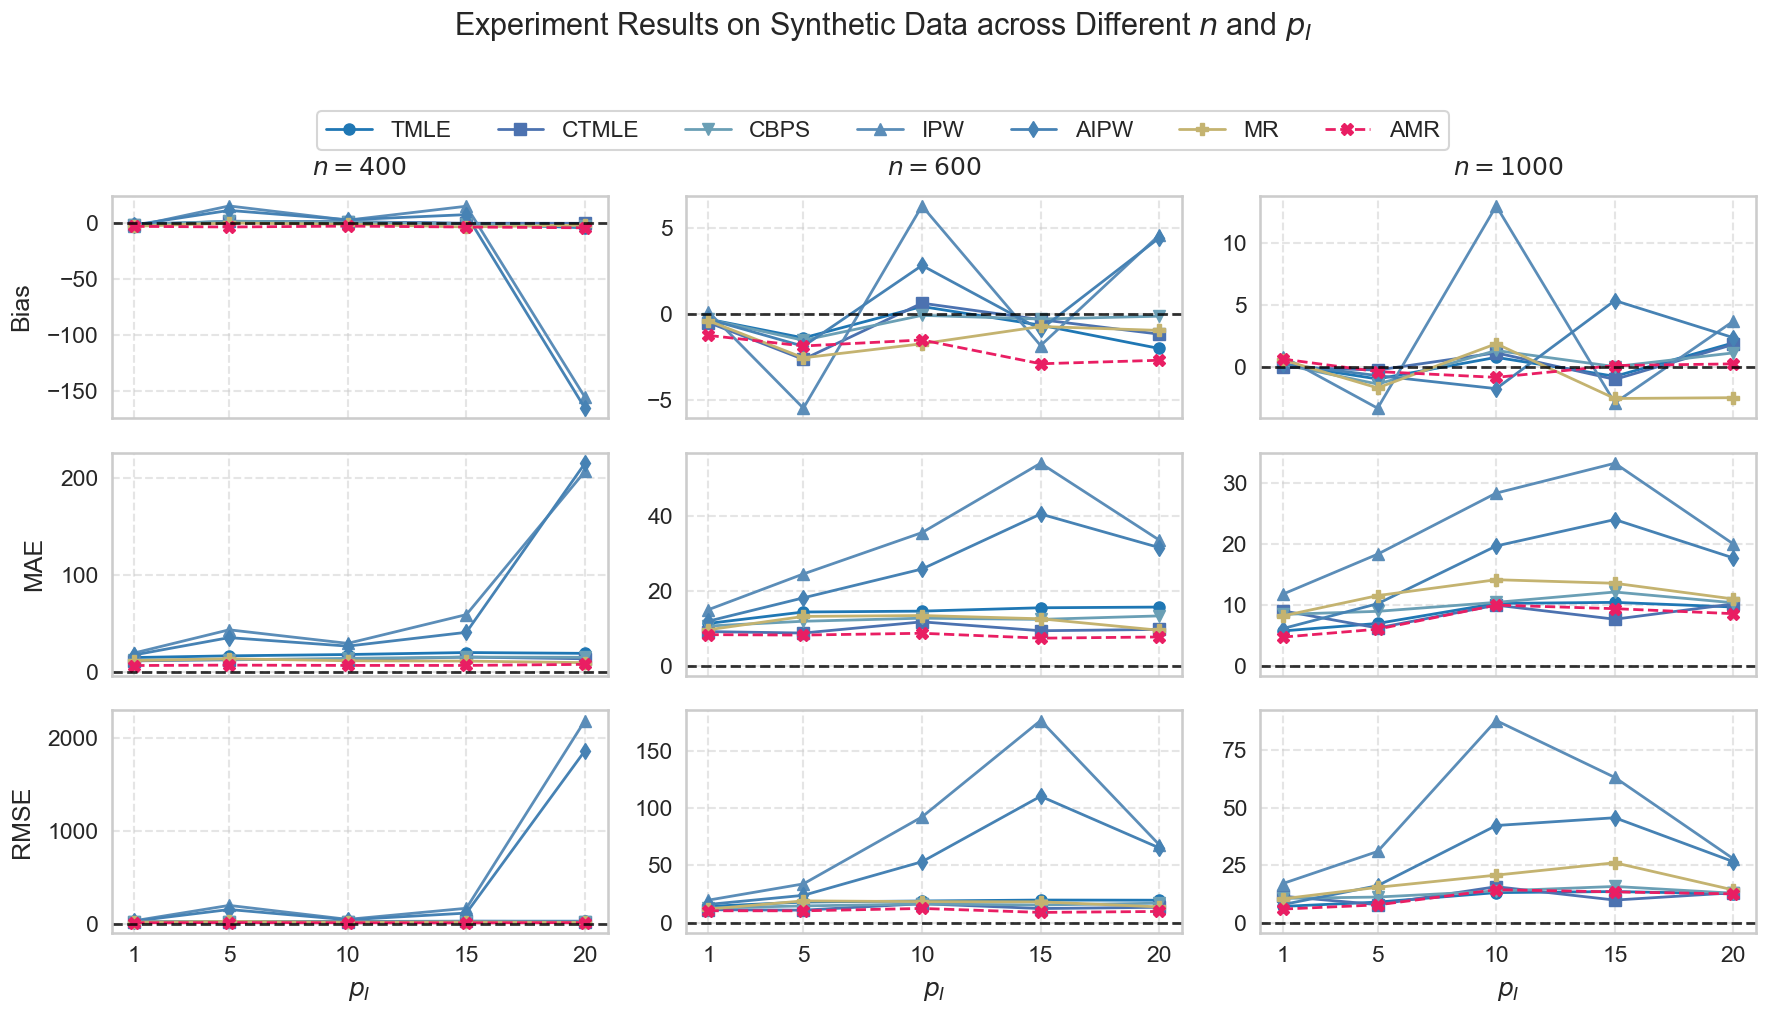

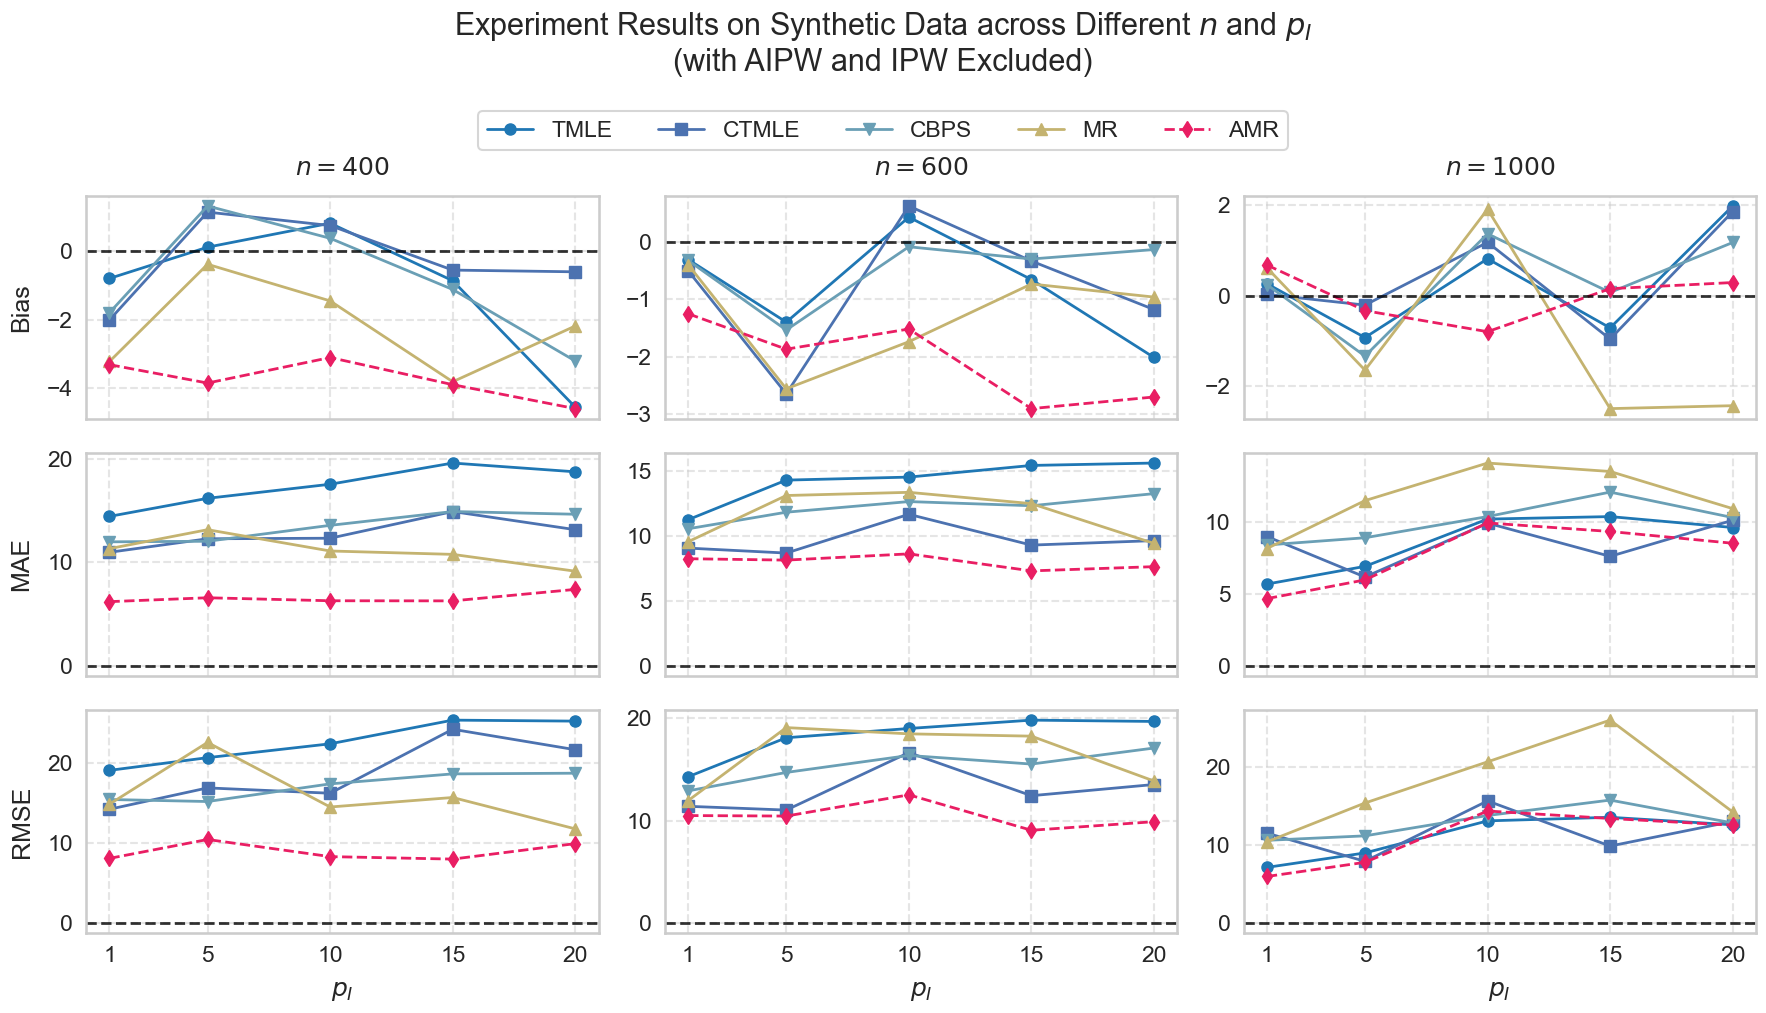

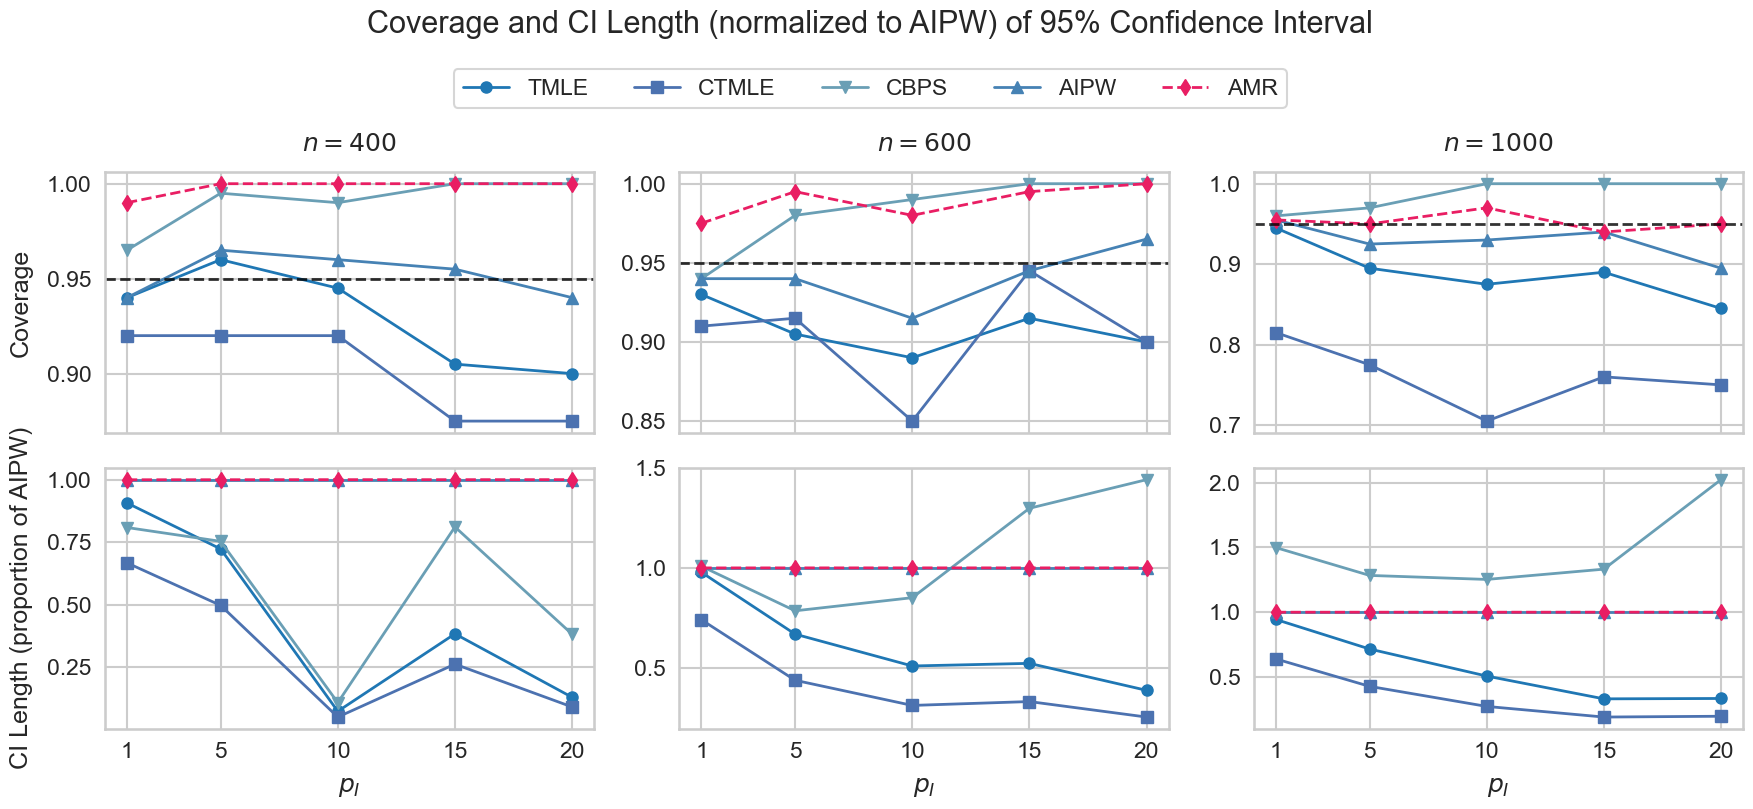

\begin{table}[ht]
\begin{center}
\resizebox{\textwidth}{!}{%
\begin{tabular}{rrrrrrr}
\toprule
 &  & TMLE & CTMLE & CBPS & AIPW & AMR \\
n & p_I &  &  &  &  &  \\
\midrule
\multirow[t]{5}{*}{400} & 1 & $$ 0.94 $$ & $$ 0.92 $$ & $$ 0.965 $$ & $$ 0.94 $$ & $$ 0.99 $$ \\
 & 5 & $$ 0.96 $$ & $$ 0.92 $$ & $$ 0.995 $$ & $$ 0.965 $$ & $$ 1 $$ \\
 & 10 & $$ 0.945 $$ & $$ 0.92 $$ & $$ 0.99 $$ & $$ 0.96 $$ & $$ 1 $$ \\
 & 15 & $$ 0.905 $$ & $$ 0.875 $$ & $$ 1 $$ & $$ 0.955 $$ & $$ 1 $$ \\
 & 20 & $$ 0.9 $$ & $$ 0.875 $$ & $$ 1 $$ & $$ 0.94 $$ & $$ 1 $$ \\
\cline{1-7}
\multirow[t]{5}{*}{600} & 1 & $$ 0.93 $$ & $$ 0.91 $$ & $$ 0.94 $$ & $$ 0.94 $$ & $$ 0.975 $$ \\
 & 5 & $$ 0.905 $$ & $$ 0.915 $$ & $$ 0.98 $$ & $$ 0.94 $$ & $$ 0.995 $$ \\
 & 10 & $$ 0.89 $$ & $$ 0.85 $$ & $$ 0.99 $$ & $$ 0.915 $$ & $$ 0.98 $$ \\
 & 15 & $$ 0.915 $$ & $$ 0.945 $$ & $$ 1 $$ & $$ 0.945 $$ & $$ 0.995 $$ \\
 & 20 & $$ 0.9 $$ & $$ 0.9 $$ & $$ 1 $$ & $$ 0.965 $$ & $$ 1 $$ \\
\cline{1-7}
\multirow[t]{5}{*}{1000} & 1 & $$ 

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from matplotlib.lines import Line2D

# ==========================================================
#  Global Settings for Colors and Markers (for consistency)
# ==========================================================
global_colors = {
    'ate_tmle':  "#1F77B4",  # standard blue
    'ate_ctmle': "#4C72B0",  # deep blue
    'ate_cbps':  "#6A9FB5",  # muted blue
    'ate_ipw':   "#5B8DB8",  # steel blue
    'ate_aipw':  "#4682B4",  # darker steel blue
    'ate_mr':    "#C4B370",  # mustard (brownish/gold)
    'ate_amr':   "#E91E63",  # hot pink
}



default_markers = ["o", "s", "v", "^", "d", "P", "X"]

def get_disp_label(method):
    return "DOPE" if method == "ate_sioapw" else method.replace("ate_", "").upper()

# Set custom fonts and styles via rcParams for a professional look.
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "axes.labelsize": 18,
    "axes.titlesize": 20,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 16,
    "figure.titlesize": 22
})

# ==========================================================
# 1. Plotting ATE Metrics: Bias, MAE, RMSE
# ==========================================================
n_list = [400, 600, 1000]
p_instr_list = [1, 5, 10, 15, 20]
methods = [
    'ate_tmle', 'ate_ctmle', 'ate_cbps', 'ate_ipw', 'ate_aipw',
    'ate_mr', 'ate_amr', 'ate_siaipw', 'ate_sioapw', 'ate_siobpw'
]

# Aggregate summary statistics into a nested dictionary.
summary = {n: {} for n in n_list}
for n in n_list:
    for p_instr in p_instr_list:
        filename = f"results/CollaborativeLearning/causl_non_linear/ate_n{n}_s{p_instr}.joblib"
        try:
            ate_results = joblib.load(filename)
        except Exception as e:
            print(f"Could not load {filename}: {e}")
            continue

        true_ate = np.array(ate_results['true_ate'])
        summary[n][p_instr] = {}
        for method in methods:
            estimates = np.array(ate_results[method])
            bias = estimates - true_ate
            abs_bias = np.abs(bias)
            summary[n][p_instr][method] = {
                'bias_mean': np.mean(bias),
                'bias_std': np.std(bias, ddof=1),
                'abs_bias_mean': np.mean(abs_bias),
                'abs_bias_std': np.std(abs_bias, ddof=1),
                'rmse': np.sqrt(np.mean(bias**2))
            }

# Exclude some methods from plotting.
exclude_plot = ['ate_siaipw', 'ate_sioapw', 'ate_siobpw']
plot_methods = [m for m in methods if m not in exclude_plot]
colors = {m: global_colors[m] for m in plot_methods}
marker_map = dict(zip(plot_methods, default_markers))

# Use a clean Seaborn theme.
sns.set_theme(style="whitegrid", context="talk")

fig, axes = plt.subplots(nrows=3, ncols=len(n_list), figsize=(6*len(n_list), 10), sharex='col')

for col_idx, n in enumerate(n_list):
    for method in plot_methods:
        x_vals, bias_mean_list, mae_list, rmse_list = [], [], [], []
        for p in p_instr_list:
            if p in summary[n]:
                data = summary[n][p].get(method, None)
                if data is not None:
                    x_vals.append(p)
                    bias_mean_list.append(data['bias_mean'])
                    mae_list.append(data['abs_bias_mean'])
                    rmse_list.append(data['rmse'])
        if not x_vals:
            continue
        x_vals = np.array(x_vals)
        # For "ate_amr", use dashed line.
        ls = '--' if method == "ate_amr" else '-'
        lw = 2
        ms = 8
        # Plot Bias
        axes[0, col_idx].plot(x_vals, bias_mean_list,
                              color=colors[method],
                              marker=marker_map[method],
                              lw=lw, markersize=ms, ls=ls,
                              label=get_disp_label(method))
        # Plot MAE
        axes[1, col_idx].plot(x_vals, mae_list,
                              color=colors[method],
                              marker=marker_map[method],
                              lw=lw, markersize=ms, ls=ls,
                              label=get_disp_label(method))
        # Plot RMSE
        axes[2, col_idx].plot(x_vals, rmse_list,
                              color=colors[method],
                              marker=marker_map[method],
                              lw=lw, markersize=ms, ls=ls,
                              label=get_disp_label(method))
    
    axes[0, col_idx].set_title(f"$n = {n}$", pad=15)
    axes[2, col_idx].set_xlabel(r"$p_I$", labelpad=10)
    for row in range(3):
        axes[row, col_idx].set_xticks(p_instr_list)
        axes[row, col_idx].tick_params(axis="both", which="both", length=6)
        # Enhanced horizontal zero line.
        axes[row, col_idx].axhline(y=0, color='black', linestyle='--', lw=2, alpha=0.8)
        axes[row, col_idx].grid(True, linestyle='--', alpha=0.5)

axes[0, 0].set_ylabel("Bias", labelpad=10)
axes[1, 0].set_ylabel("MAE", labelpad=10)
axes[2, 0].set_ylabel("RMSE", labelpad=10)

plt.tight_layout(rect=[0, 0, 1, 0.90])
# Create one overall legend and move it slightly lower.
legend_elements = []
for m in plot_methods:
    ls = '--' if m == "ate_amr" else '-'
    legend_elements.append(Line2D([0], [0],
                                  color=colors[m],
                                  lw=2,
                                  marker=marker_map[m],
                                  markersize=ms,
                                  ls=ls,
                                  label=get_disp_label(m)))
fig.legend(handles=legend_elements, loc='upper center', ncol=len(plot_methods),
           bbox_to_anchor=(0.5, 0.93))
plt.suptitle("Experiment Results on Synthetic Data across Different $n$ and $p_I$", y=1.02)
plt.show()

# ==========================================================
# 2. (Optional) Second Plot – Similar ATE Metrics Plot
# ==========================================================
# In this second plot we exclude a few more methods.
exclude_plot = ['ate_aipw','ate_ipw','ate_siaipw', 'ate_sioapw', 'ate_siobpw']
plot_methods = [m for m in methods if m not in exclude_plot]
# Re-use colors and markers for these methods.
colors = {m: global_colors[m] for m in plot_methods}
marker_map = dict(zip(plot_methods, default_markers))

fig, axes = plt.subplots(nrows=3, ncols=len(n_list), figsize=(6*len(n_list), 10), sharex='col')

for col_idx, n in enumerate(n_list):
    for method in plot_methods:
        x_vals, bias_mean_list, mae_list, rmse_list = [], [], [], []
        for p in p_instr_list:
            if p in summary[n]:
                data = summary[n][p].get(method, None)
                if data is not None:
                    x_vals.append(p)
                    bias_mean_list.append(data['bias_mean'])
                    mae_list.append(data['abs_bias_mean'])
                    rmse_list.append(data['rmse'])
        if not x_vals:
            continue
        x_vals = np.array(x_vals)
        ls = '--' if method == "ate_amr" else '-'
        lw = 2
        ms = 8
        # Plot each metric.
        axes[0, col_idx].plot(x_vals, bias_mean_list,
                              color=colors[method],
                              marker=marker_map[method],
                              lw=lw, markersize=ms, ls=ls,
                              label=get_disp_label(method))
        axes[1, col_idx].plot(x_vals, mae_list,
                              color=colors[method],
                              marker=marker_map[method],
                              lw=lw, markersize=ms, ls=ls,
                              label=get_disp_label(method))
        axes[2, col_idx].plot(x_vals, rmse_list,
                              color=colors[method],
                              marker=marker_map[method],
                              lw=lw, markersize=ms, ls=ls,
                              label=get_disp_label(method))
    axes[0, col_idx].set_title(f"$n = {n}$", pad=15)
    axes[2, col_idx].set_xlabel(r"$p_I$", labelpad=10)
    for row in range(3):
        axes[row, col_idx].set_xticks(p_instr_list)
        axes[row, col_idx].tick_params(axis="both", which="both", length=6)
        axes[row, col_idx].axhline(y=0, color='black', linestyle='--', lw=2, alpha=0.8)
        axes[row, col_idx].grid(True, linestyle='--', alpha=0.5)

axes[0, 0].set_ylabel("Bias", labelpad=10)
axes[1, 0].set_ylabel("MAE", labelpad=10)
axes[2, 0].set_ylabel("RMSE", labelpad=10)

plt.tight_layout(rect=[0, 0, 1, 0.90])
legend_elements = [Line2D([0], [0],
                          color=colors[m],
                          lw=2,
                          marker=marker_map[m],
                          markersize=ms,
                          ls='--' if m=="ate_amr" else '-',
                          label=get_disp_label(m))
                   for m in plot_methods]
fig.legend(handles=legend_elements, loc='upper center', ncol=len(plot_methods),
           bbox_to_anchor=(0.5, 0.93))
plt.suptitle("Experiment Results on Synthetic Data across Different $n$ and $p_I$\n(with AIPW and IPW Excluded)", y=1.02)
plt.show()

# ==========================================================
# 3. Plotting Coverage & CI Length (with LaTeX Tables)
# ==========================================================
n_list_cov = [400, 600, 1000]
p_instr_list = [1, 5, 10, 15, 20]
methods_cov = ['ate_tmle', 'ate_ctmle', 'ate_cbps', 'ate_aipw', 'ate_amr']
colors_cov = {m: global_colors[m] for m in methods_cov}
marker_map_cov = dict(zip(methods_cov, default_markers))

coverage_summary = {n: {} for n in n_list_cov}
length_summary   = {n: {} for n in n_list_cov}

for n in n_list_cov:
    for p_instr in p_instr_list:
        ate_filename = f"results/CollaborativeLearning/causl_non_linear/new/ate_n{n}_s{p_instr}.joblib"
        std_filename = f"results/CollaborativeLearning/causl_non_linear/new/std_n{n}_s{p_instr}.joblib"
        try:
            ate_results = joblib.load(ate_filename)
            std_results = joblib.load(std_filename)
        except Exception as e:
            print(f"Could not load {ate_filename} or {std_filename}: {e}")
            continue
        
        true_ate = np.array(ate_results['true_ate'])
        coverage_summary[n][p_instr] = {}
        length_summary[n][p_instr]   = {}
        for method in methods_cov:
            estimates = np.array(ate_results[method])
            std_key = method.replace("ate_", "std_")
            stds = np.array(std_results[std_key])
            lower = estimates - 1.96 * stds
            upper = estimates + 1.96 * stds
            coverage = np.mean((true_ate >= lower) & (true_ate <= upper))
            ci_length = np.mean(upper - lower)
            coverage_summary[n][p_instr][method] = coverage
            length_summary[n][p_instr][method]   = ci_length

sns.set_theme(style="whitegrid", context="talk")
fig, axes = plt.subplots(nrows=2, ncols=len(n_list_cov), figsize=(6*len(n_list_cov), 8), sharex='col')

default_lw = 2
default_ms = 8

for col_idx, n in enumerate(n_list_cov):
    for method in methods_cov:
        x_vals, cov_vals, len_vals = [], [], []
        for p in p_instr_list:
            if p in coverage_summary[n]:
                cov = coverage_summary[n][p].get(method, None)
                if p in length_summary[n] and length_summary[n][p].get('ate_aipw', 0) != 0:
                    ratio = length_summary[n][p][method] / length_summary[n][p]['ate_aipw']
                else:
                    ratio = None
                if cov is not None and ratio is not None:
                    x_vals.append(p)
                    cov_vals.append(cov)
                    len_vals.append(ratio)
        if not x_vals:
            continue
        x_vals = np.array(x_vals)
        ls = '--' if method == "ate_amr" else '-'
        # Top row: Coverage
        axes[0, col_idx].plot(x_vals, cov_vals,
                              color=colors_cov[method],
                              marker=marker_map_cov[method],
                              lw=default_lw, markersize=default_ms, ls=ls,
                              label=get_disp_label(method))
        # Bottom row: CI Length ratio (relative to AIPW)
        axes[1, col_idx].plot(x_vals, len_vals,
                              color=colors_cov[method],
                              marker=marker_map_cov[method],
                              lw=default_lw, markersize=default_ms, ls=ls,
                              label=get_disp_label(method))
    axes[0, col_idx].axhline(0.95, color='black', linestyle='--', lw=2, alpha=0.8)
    axes[0, col_idx].set_title(f"$n = {n}$", pad=15)
    for row in range(2):
        axes[row, col_idx].set_xticks(p_instr_list)
        axes[row, col_idx].tick_params(axis="both", which="both", length=6)
    axes[1, col_idx].set_xlabel(r"$p_I$", labelpad=10)

axes[0, 0].set_ylabel("Coverage", labelpad=10)
axes[1, 0].set_ylabel("CI Length (proportion of AIPW)", labelpad=10)

plt.tight_layout(rect=[0, 0, 1, 0.90])
legend_elements_cov = [Line2D([0], [0],
                              color=colors_cov[m],
                              lw=default_lw,
                              marker=marker_map_cov[m],
                              markersize=default_ms,
                              ls='--' if m=="ate_amr" else '-',
                              label=get_disp_label(m))
                       for m in methods_cov]
fig.legend(handles=legend_elements_cov, loc='upper center', ncol=len(methods_cov),
           bbox_to_anchor=(0.5, 0.96))
plt.suptitle(r"Coverage and CI Length (normalized to AIPW) of 95% Confidence Interval", y=1.02)
plt.show()

# ---------------------------
# Creating LaTeX Tables (Coverage & CI Length)
# ---------------------------
rows_cov = []
rows_len = []

for n in n_list_cov:
    for p in p_instr_list:
        if p not in coverage_summary[n]:
            continue
        row_cov = {"n": n, "p_I": p}
        row_len = {"n": n, "p_I": p}
        for method in methods_cov:
            disp_label = get_disp_label(method)
            if method in coverage_summary[n][p]:
                cov_val = coverage_summary[n][p][method]
                if 'ate_aipw' in length_summary[n][p] and length_summary[n][p]['ate_aipw'] != 0:
                    len_ratio = length_summary[n][p][method] / length_summary[n][p]['ate_aipw']
                else:
                    len_ratio = None
                row_cov[disp_label] = f"$$ {cov_val:.3g} $$"
                row_len[disp_label] = f"$$ {len_ratio:.3g} $$" if len_ratio is not None else ""
            else:
                row_cov[disp_label] = ""
                row_len[disp_label] = ""
        rows_cov.append(row_cov)
        rows_len.append(row_len)

df_cov = pd.DataFrame(rows_cov).set_index(["n", "p_I"])
df_len = pd.DataFrame(rows_len).set_index(["n", "p_I"])

col_format_cov = "r" * (df_cov.index.nlevels + len(df_cov.columns))
col_format_len = "r" * (df_len.index.nlevels + len(df_len.columns))

latex_cov = df_cov.to_latex(multirow=True, escape=False, column_format=col_format_cov)
latex_len = df_len.to_latex(multirow=True, escape=False, column_format=col_format_len)

latex_cov = "\\begin{table}[ht]\n\\begin{center}\n" + \
            "\\resizebox{\\textwidth}{!}{%\n" + latex_cov + "\n}" + \
            "\n\\end{center}\n\\end{table}"
latex_len = "\\begin{table}[ht]\n\\begin{center}\n" + \
            "\\resizebox{\\textwidth}{!}{%\n" + latex_len + "\n}" + \
            "\n\\end{center}\n\\end{table}"

print(latex_cov)
print(latex_len)


/var/folders/34/4pny9pxj7z31glf0phhx3b280000gn/T/ipykernel_1200/804499956.py:28: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ate_aipw, shade=True, color='blue', label='AIPW', bw_adjust=0.5)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/34/4pny9pxj7z31glf0phhx3b280000gn/T/ipykernel_1200/804499956.py:29: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ate_amr, shade=True, color='orange', label='AMR', bw_adjust=1)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na opti

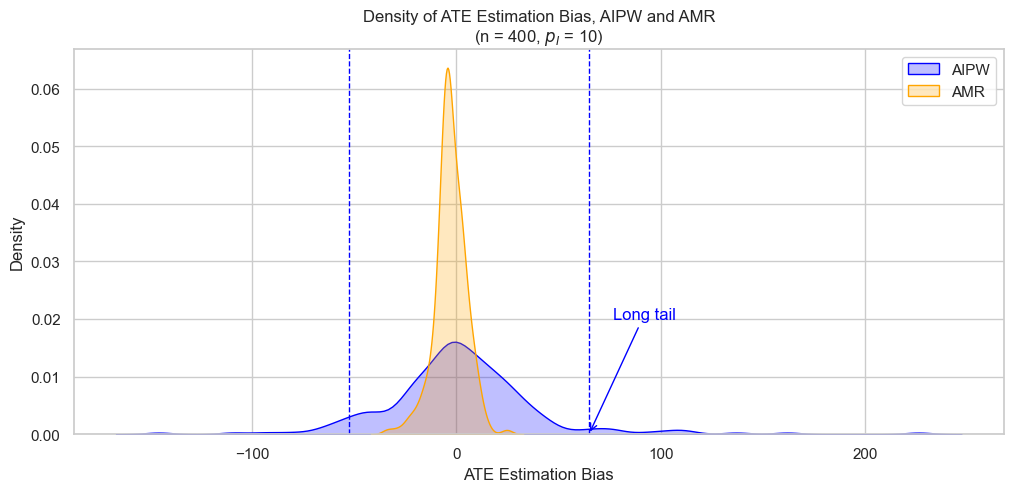

In [6]:
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Settings: use n=400 and p_I=10
n = 400
p = 10

# Construct the filename and load the ATE results.
ate_filename = f"results/CollaborativeLearning/causl_non_linear/ate_n{n}_s{p}.joblib"
try:
    ate_results = joblib.load(ate_filename)
except Exception as e:
    print(f"Could not load {ate_filename}: {e}")
    exit()

# Extract the ATE estimations for AIPW and AMR.
ate_aipw = np.array(ate_results['ate_aipw'])-np.array(ate_results['true_ate'])
ate_amr  = np.array(ate_results['ate_amr'])-np.array(ate_results['true_ate'])

# Set up the plot.
sns.set(style="whitegrid")
plt.figure(figsize=(12, 5))

# Plot density (kernel density estimate) for both methods.
# For AIPW, we use a lower bw_adjust to show a sharper, more concentrated peak.
sns.kdeplot(ate_aipw, shade=True, color='blue', label='AIPW', bw_adjust=0.5)
sns.kdeplot(ate_amr, shade=True, color='orange', label='AMR', bw_adjust=1)

# For AIPW, compute percentiles to locate the tail.
aipw_95 = np.percentile(ate_aipw, 95)
aipw_5  = np.percentile(ate_aipw, 5)

# Draw vertical dashed lines at the 5th and 95th percentiles of AIPW.
plt.axvline(aipw_5, color='blue', linestyle='--', lw=1)
plt.axvline(aipw_95, color='blue', linestyle='--', lw=1)

# Annotate the long tail for AIPW.
plt.annotate("Long tail", 
             xy=(aipw_95, 0), 
             xytext=(aipw_95 + 0.1*(aipw_95 - aipw_5), 0.02), 
             arrowprops=dict(arrowstyle="->", color='blue'),
             color='blue')

# Set labels and title.
plt.xlabel("ATE Estimation Bias")
plt.ylabel("Density")
plt.title("Density of ATE Estimation Bias, AIPW and AMR\n(n = 400, $p_I$ = 10)")
plt.legend()

plt.show()


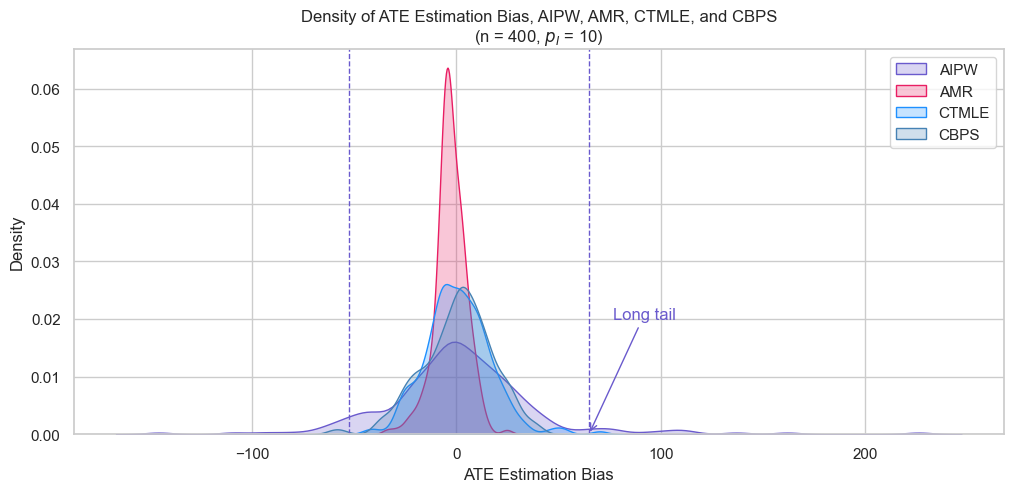

In [17]:
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Settings: use n=400 and p_I=10
n = 400
p = 10

# Construct the filename and load the ATE results.
ate_filename = f"results/CollaborativeLearning/causl_non_linear/ate_n{n}_s{p}.joblib"
try:
    ate_results = joblib.load(ate_filename)
except Exception as e:
    print(f"Could not load {ate_filename}: {e}")
    exit()

# Extract the ATE estimation biases.
ate_aipw  = np.array(ate_results['ate_aipw']) - np.array(ate_results['true_ate'])
ate_amr   = np.array(ate_results['ate_amr']) - np.array(ate_results['true_ate'])
ate_ctmle = np.array(ate_results['ate_ctmle']) - np.array(ate_results['true_ate'])
ate_cbps  = np.array(ate_results['ate_cbps']) - np.array(ate_results['true_ate'])

# Define improved colors
global_colors = {
    'ate_ctmle': "#1E90FF",  # Dodger Blue (bright, noticeable)
    'ate_cbps':  "#4682B4",  # Steel Blue (darker, neutral)
    'ate_aipw':  "#6A5ACD",  # Slate Blue (purple hue, distinct)
    'ate_mr':    "#C4B370",  # Mustard (unchanged)
    'ate_amr':   "#E91E63",  # Hot Pink (unchanged)
}

# Set up the plot.
sns.set(style="whitegrid")
plt.figure(figsize=(12, 5))

# Plot density (kernel density estimate) for each method.
sns.kdeplot(ate_aipw, shade=True, color=global_colors['ate_aipw'], label='AIPW', bw_adjust=0.5)
sns.kdeplot(ate_amr, shade=True, color=global_colors['ate_amr'], label='AMR', bw_adjust=1)
sns.kdeplot(ate_ctmle, shade=True, color=global_colors['ate_ctmle'], label='CTMLE', bw_adjust=0.7)
sns.kdeplot(ate_cbps, shade=True, color=global_colors['ate_cbps'], label='CBPS', bw_adjust=0.7)

# For AIPW, compute percentiles to locate the tail.
aipw_95 = np.percentile(ate_aipw, 95)
aipw_5  = np.percentile(ate_aipw, 5)

# Draw vertical dashed lines at the 5th and 95th percentiles of AIPW.
plt.axvline(aipw_5, color=global_colors['ate_aipw'], linestyle='--', lw=1)
plt.axvline(aipw_95, color=global_colors['ate_aipw'], linestyle='--', lw=1)

# Annotate the long tail for AIPW.
plt.annotate("Long tail", 
             xy=(aipw_95, 0), 
             xytext=(aipw_95 + 0.1*(aipw_95 - aipw_5), 0.02), 
             arrowprops=dict(arrowstyle="->", color=global_colors['ate_aipw']),
             color=global_colors['ate_aipw'])

# Set labels and title.
plt.xlabel("ATE Estimation Bias")
plt.ylabel("Density")
plt.title("Density of ATE Estimation Bias, AIPW, AMR, CTMLE, and CBPS\n(n = 400, $p_I$ = 10)")
plt.legend()

plt.show()
